# Praktikum M6 Audio
## Amalika Ari Anindya (164221029)

Kaggle Heartbeat Sound Link: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds

Pakai set b (buat testing)

# Import Library

In [1]:
import wave
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import os
import librosa as lr

# Import Dataset

In [2]:
datake = 0
file = os.listdir('./heartbeat/set_b')[datake]
wav_file = wave.open('./heartbeat/set_b/'+file, 'rb')

# Get basic information about the wav file

In [3]:
num_channels = wav_file.getnchannels()
sample_width = wav_file.getsampwidth()
frame_rate = wav_file.getframerate() # Samples per second
num_frames = wav_file.getnframes()
duration = num_frames / float(frame_rate) # dalam seconds

print(f"Channels: {num_channels}")
print(f"Sample Width: {sample_width} bytes")
print(f"Frame Rate: {frame_rate} Hz")
print(f"Number of frames: {num_frames}")
print(f"Duration: {duration:.2f} seconds")

Channels: 1
Sample Width: 2 bytes
Frame Rate: 4000 Hz
Number of frames: 42385
Duration: 10.60 seconds


Atribut sinyal pake method
Ga perlu konversi dari analog ke digital

1. Channel: kanan atau kiri
2. Sample width: nunjukin berapa bit dari datanya
3. Framerate: sample ratenya dapet dari sound
4. Number of frames: jumlah sampelnya
5. Duration: number of frames/framerate

dari framerate dan number of frames bisa diambil audionya kira kira berapa menit/detik

- 1 bytes = 8 bit
- 2 bytes = 16 bit

# Ambil array dari sound
Membentuk feature vector yang dasar menggunakan numpy

In [4]:
frames = wav_file.readframes(num_frames) # membaca jumlah frame dari audio
wav_file.close() # menutup audio

In [5]:
audio_data = np.frombuffer(frames, dtype=np.int16) 

- ubah ke array pakai numpy
- dtype int16 karena 2 bytes = 16bit (liat di sample width)
- efeknya ke maksimum minumum nilai amplitudo

Kebetulan di atas channelnya cuma satu, tapi kalau dua bisa digabungkan jadi satu channel pakai reshape. Boleh aja kalau mau channelnya tetep >1 tapi clusteringnya berat.

In [6]:
if num_channels > 1:
    audio_data = np.reshape(audio_data, (-1, num_channels))

In [7]:
print("Audio Array:", audio_data)
print("Array Shape:", audio_data.shape)

Audio Array: [-204 -117   90 ...  495  575  594]
Array Shape: (42385,)


# Plot Waveform menggunakan Matplotlib

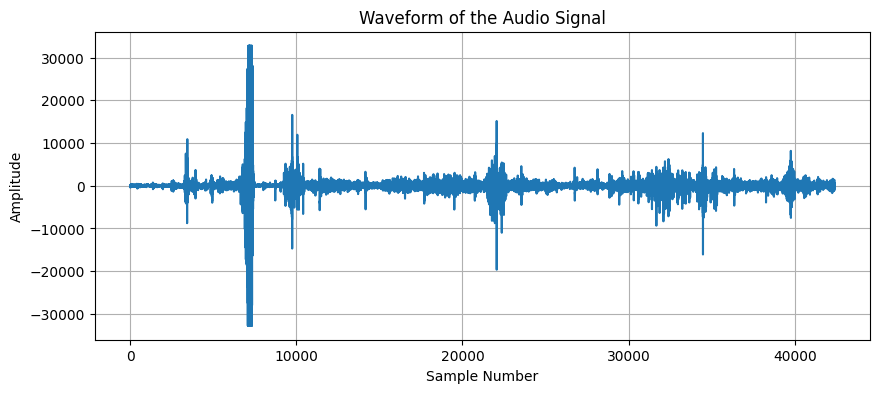

In [8]:
plt.figure(figsize=(10,4))
if num_channels > 1:
    plt.plot(audio_data[:, 0])
else: 
    plt.plot(audio_data)
plt.title("Waveform of the Audio Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

Audio array terlihat amplitudonya sampai 30k karena 16bit

# Feature extraction
Convert your raw audio data into a more compact representation using audio features such as MFCCs or spectrograms.

## MFCCs: Mel-frequency cepstral coefficients 

Convert your audio_data array into a format usable by librosa

In [9]:
import librosa

mfcc_features = librosa.feature.mfcc(y=audio_data.astype(float), sr=frame_rate, n_mfcc=13)

# Pre-processing

## Normalize the MFCC features

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mfcc_scaled = scaler.fit_transform(mfcc_features.T)  # Transpose so each row is a time frame

## Dimensionality Reduction
UMAP can help reduce noise and highlight important structures in your data. Reducing the dimensionality might help the clustering algorithm to perform better, as it simplifies the feature space.

In [11]:
import umap
umap_reducer = umap.UMAP(n_components=2, n_jobs=1, random_state=42)
mfcc_umap = umap_reducer.fit_transform(mfcc_scaled)

# Clustering

## Kmeans

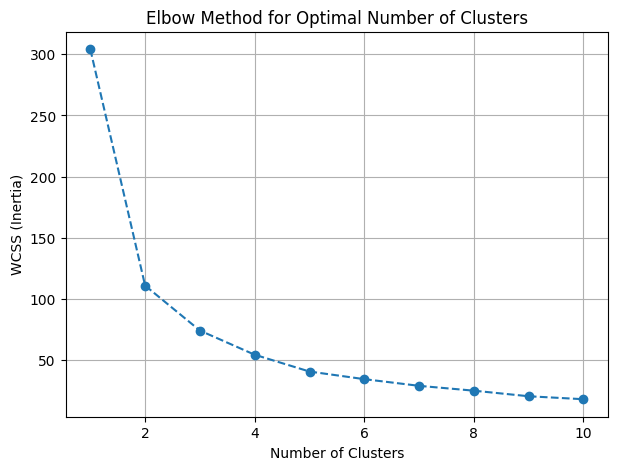

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define the range for the number of clusters
cluster_range = range(1,11)
inertia = []

# Apply KMeans for each number of clusters and store the inertia (WCSS)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(mfcc_umap)
    inertia.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the number of clusters vs. WCSS (Inertia)
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

In [13]:
n_clusters = 2 # You can change the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(mfcc_umap)

# Get the labels for each segment of the audio
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

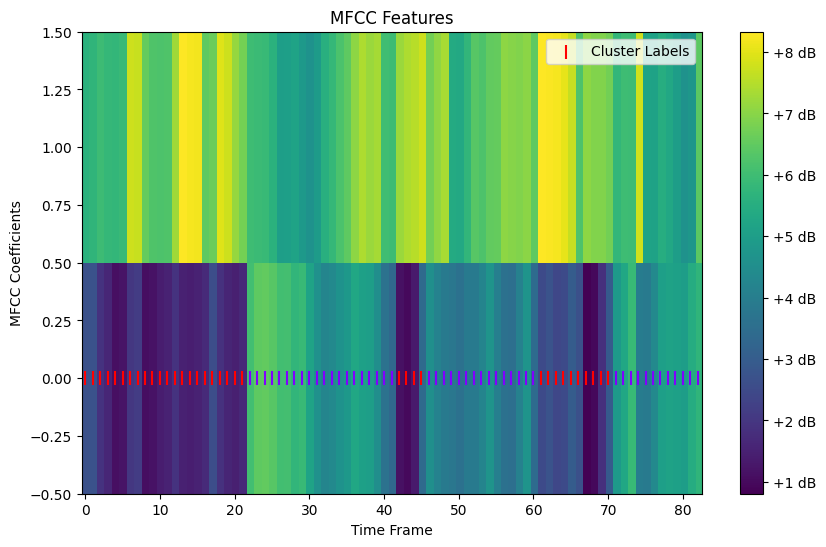

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the MFCCs with their cluster labels
plt.figure(figsize=(10, 6))
plt.imshow(mfcc_umap.T, aspect='auto', origin='lower')
plt.title('MFCC Features')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time Frame')
plt.colorbar(format="%+2.0f dB")

# Add the cluster labels
plt.scatter(np.arange(len(cluster_labels)), [0] * len(cluster_labels), 
            c=cluster_labels, cmap='rainbow', marker='|', s=100, label="Cluster Labels")
plt.legend(loc='upper right')
plt.show()

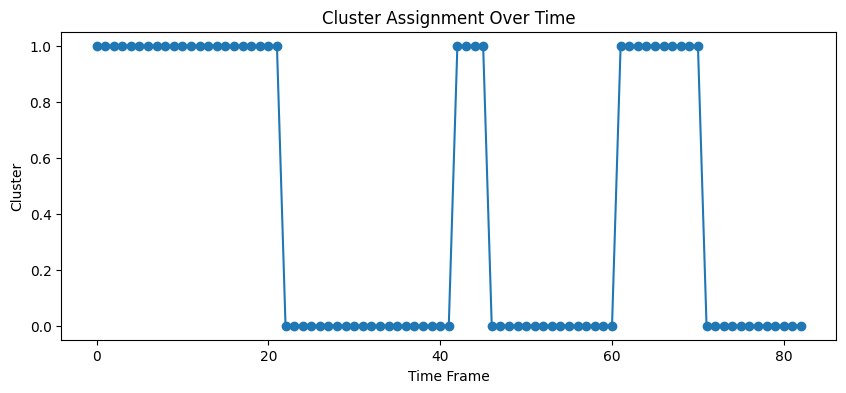

In [15]:
# Plot the clusters as segments over time
plt.figure(figsize=(10, 4))
plt.plot(cluster_labels, marker='o')
plt.title('Cluster Assignment Over Time')
plt.xlabel('Time Frame')
plt.ylabel('Cluster')
plt.show()

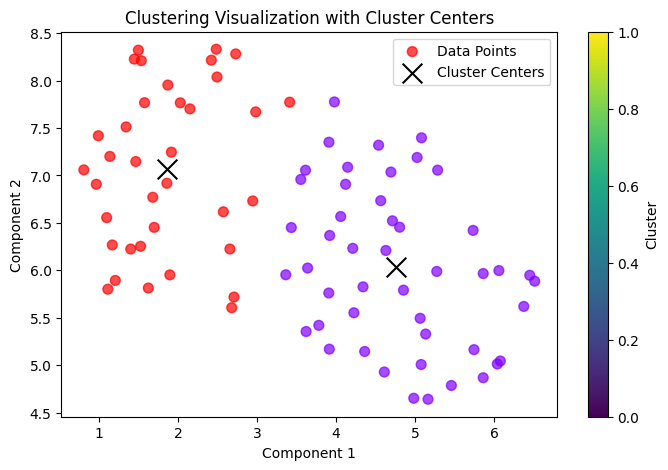

In [16]:
# Plot the blobs (clusters) with cluster centers
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7, label="Data Points")

# Mark the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=200, label="Cluster Centers")

plt.title('Clustering Visualization with Cluster Centers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.legend(loc='best')
plt.show()

### Silhouette Score

In [17]:
from sklearn.metrics import silhouette_score

sil_kmeans = silhouette_score(mfcc_umap, cluster_labels)
print(sil_kmeans)

0.52034646


## DBScan (Density-Based Spatial Clustering of Applications with Noise)

Best eps: 1.1, Best min_samples: 14, Best Silhouette Score: 0.5138709545135498


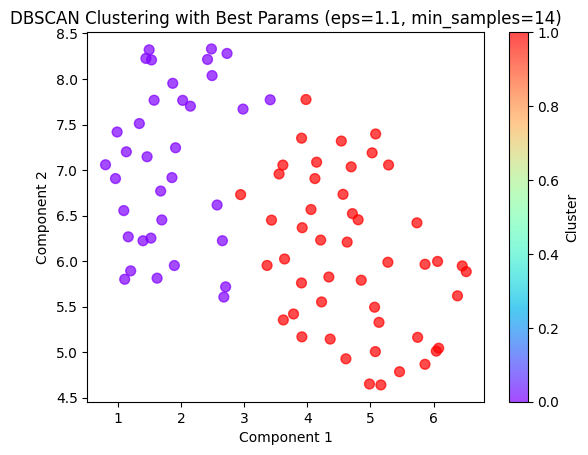

In [18]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define ranges for eps and min_samples
eps_range = np.arange(0.1, 3.0, 0.1)  # You can adjust this range
min_samples_range = range(2, 20)  # Adjust this range based on your data

best_eps = None
best_min_samples = None
best_silhouette = -1  # Initialize to a low value
best_labels = None

# Iterate over combinations of eps and min_samples
for eps in eps_range:
    for min_samples in min_samples_range:
        # Apply DBSCAN with the current eps and min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(mfcc_umap)
        
        # Only compute silhouette score if there is more than 1 cluster (and no noise points only)
        if len(set(labels)) > 1 and len(set(labels)) != 1 + (labels == -1).sum():
            sil_score = silhouette_score(mfcc_umap, labels)
            
            # Keep track of the best parameters based on silhouette score
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print(f'Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}')

# If you want to visualize the best clustering result:
# Visualize DBSCAN clustering with the best parameters
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=best_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title(f'DBSCAN Clustering with Best Params (eps={best_eps}, min_samples={best_min_samples})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()

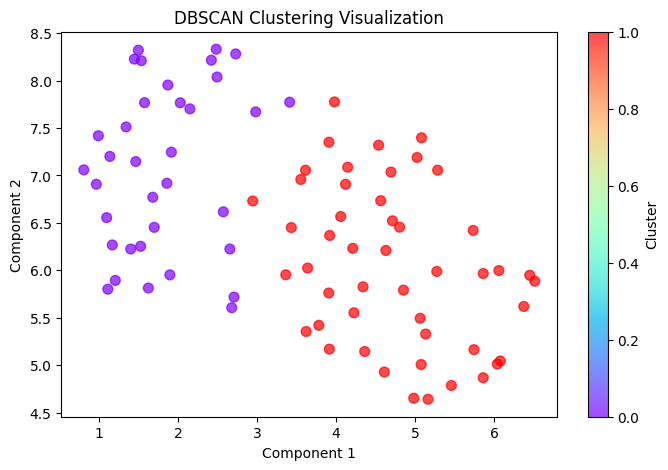

In [19]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.1, min_samples=14) 
dbscan_labels = dbscan.fit_predict(mfcc_umap)

# Visualize the DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=dbscan_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title('DBSCAN Clustering Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Silhouette Score

In [20]:
sil_dbscan = silhouette_score(mfcc_umap, dbscan_labels)
print(sil_dbscan)

0.51387095


## Hierarchical Clustering

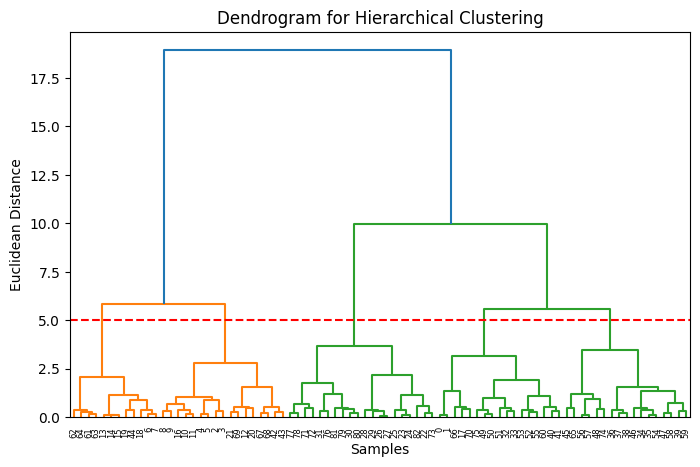

In [21]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Compute the distance matrix and perform linkage
plt.figure(figsize=(8, 5))
dendrogram = sch.dendrogram(sch.linkage(mfcc_umap, method='ward'))

# Add a horizontal line to mark the cutoff at Euclidean distance = 5
plt.axhline(y=5, color='red', linestyle='--') 

plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

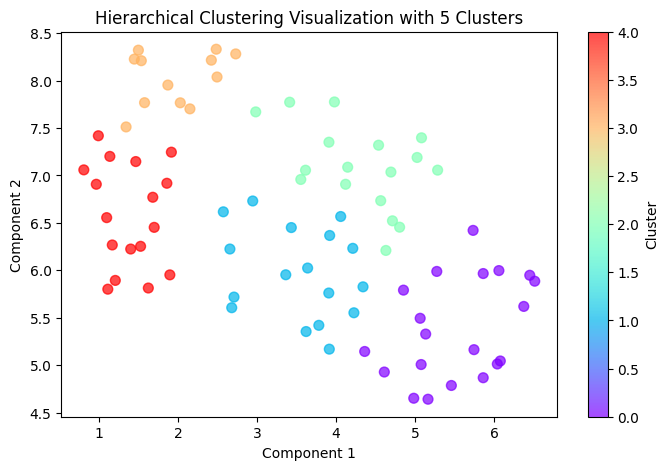

In [22]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 5
hier_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = hier_clustering.fit_predict(mfcc_umap)

# Visualize the clusters
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title(f'Hierarchical Clustering Visualization with {n_clusters} Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Silhouette Score

In [23]:
sil_hc = silhouette_score(mfcc_umap, cluster_labels)
print(sil_hc)

0.40656933


## PAM Clustering (Partitioning Around Medoids)

pip install scikit-learn-extra

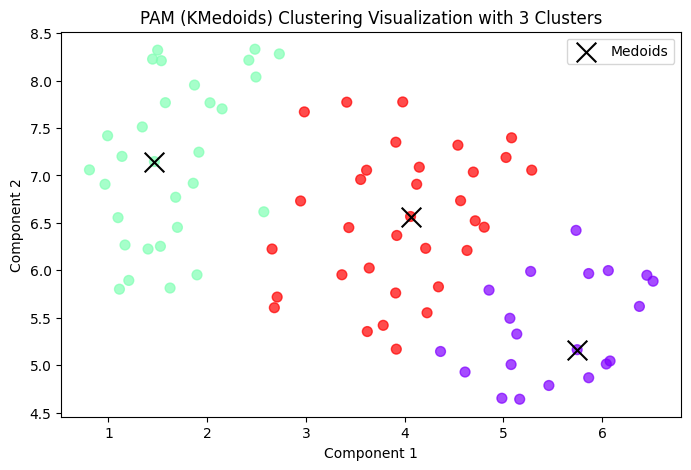

In [33]:
from sklearn_extra.cluster import KMedoids

# Apply PAM (KMedoids) Clustering
n_clusters = 3  # Set the number of clusters
pam = KMedoids(n_clusters=n_clusters, metric='euclidean', method='pam', random_state=42)
cluster_labels = pam.fit_predict(mfcc_umap)

# Visualize the clusters
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.scatter(pam.cluster_centers_[:, 0], pam.cluster_centers_[:, 1], c='black', marker='x', s=200, label="Medoids")
plt.title(f'PAM (KMedoids) Clustering Visualization with {n_clusters} Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='best')
plt.show()

- PAM is robust to outliers because it uses actual data points as medoids.
- This approach is more computationally expensive than KMeans, especially for large datasets, because PAM evaluates all possible medoids.

### Silhouette Score

In [25]:
sil_pam = silhouette_score(mfcc_umap, cluster_labels)
print(sil_pam)

0.42894396


## Means Shift Clustering

Number of Clusters: 2
Cluster Centers: 
[[4.4313593 6.2287736]
 [2.7307038 7.033101 ]]


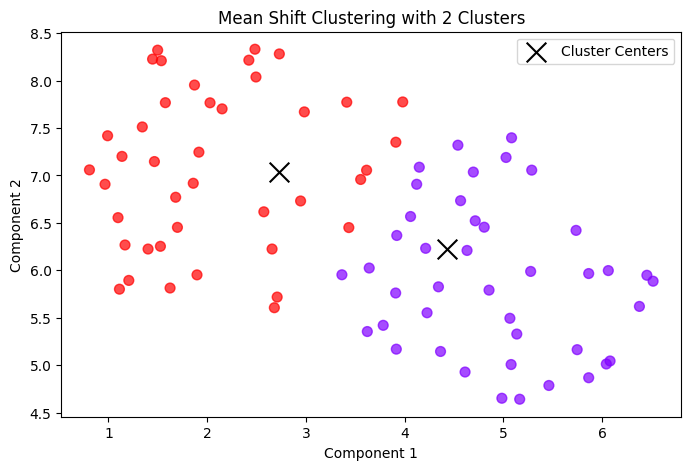

In [34]:
from sklearn.cluster import MeanShift

# Apply Mean Shift Clustering
mean_shift = MeanShift(bandwidth=None)  # You can also specify 'bandwidth' if known
cluster_labels = mean_shift.fit_predict(mfcc_umap)

# Get the cluster centers
cluster_centers = mean_shift.cluster_centers_

# Print the number of clusters and cluster centers
n_clusters = len(set(cluster_labels))
print(f'Number of Clusters: {n_clusters}')
print(f'Cluster Centers: \n{cluster_centers}')

# Visualize the clusters and cluster centers
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=200, label="Cluster Centers")
plt.title(f'Mean Shift Clustering with {n_clusters} Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='best')
plt.show()

In [27]:
sil_means = silhouette_score(mfcc_umap, cluster_labels)
print(f'Silhouette Score: {sil_means}')

Silhouette Score: 0.5019857883453369


## Affinity Propagation

Number of clusters: 2
Exemplar indices: [12 71]
Silhouette Score: 0.5072


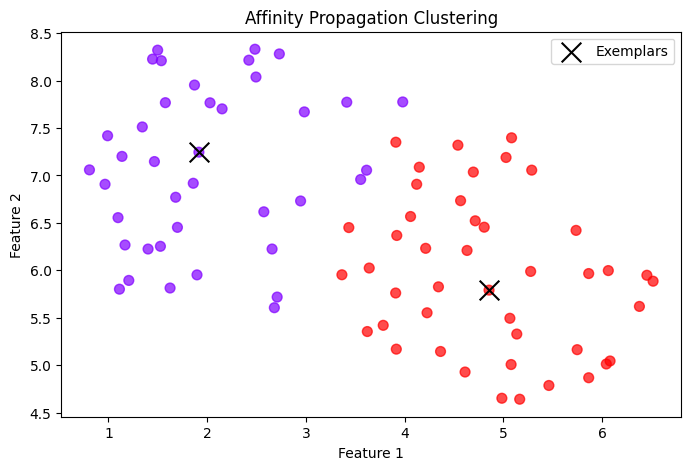

In [28]:
from sklearn.cluster import AffinityPropagation

# Apply Affinity Propagation
affinity_propagation = AffinityPropagation(damping=0.5, preference=-50, random_state=42)
cluster_labels = affinity_propagation.fit_predict(mfcc_umap)

# Get the number of clusters and exemplars
n_clusters = len(np.unique(cluster_labels))
exemplars_indices = affinity_propagation.cluster_centers_indices_

# Print the number of clusters
print(f'Number of clusters: {n_clusters}')
print(f'Exemplar indices: {exemplars_indices}')

# Calculate and print the silhouette score
if n_clusters > 1:  # Silhouette score is not defined for a single cluster
    sil_affi = silhouette_score(mfcc_umap, cluster_labels)
    print(f'Silhouette Score: {sil_affi:.4f}')

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.scatter(mfcc_umap[exemplars_indices, 0], mfcc_umap[exemplars_indices, 1], c='black', marker='x', s=200, label='Exemplars')
plt.title('Affinity Propagation Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.show()

## Spectral Clustering

Number of clusters: 2, Silhouette Score: 0.5108
Number of clusters: 3, Silhouette Score: 0.4266
Number of clusters: 4, Silhouette Score: 0.3979
Number of clusters: 5, Silhouette Score: 0.4083
Number of clusters: 6, Silhouette Score: 0.3905
Number of clusters: 7, Silhouette Score: 0.3732
Number of clusters: 8, Silhouette Score: 0.3497
Number of clusters: 9, Silhouette Score: 0.3716


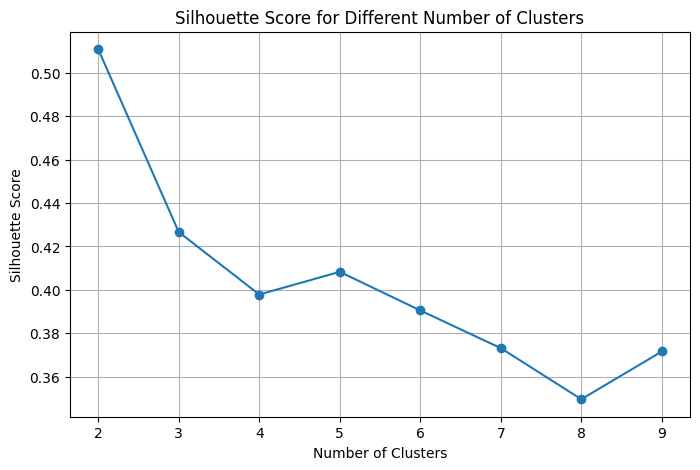

In [29]:
from sklearn.cluster import SpectralClustering

silhouette_scores = []
cluster_range = range(2, 10)  # Adjust this range as needed

for n_clusters in cluster_range:
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral_clustering.fit_predict(mfcc_umap)
    
    if n_clusters > 1:  # Silhouette score is not defined for a single cluster
        sil_score = silhouette_score(mfcc_umap, cluster_labels)
        silhouette_scores.append(sil_score)
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {sil_score:.4f}')

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

Silhouette Score: 0.5108


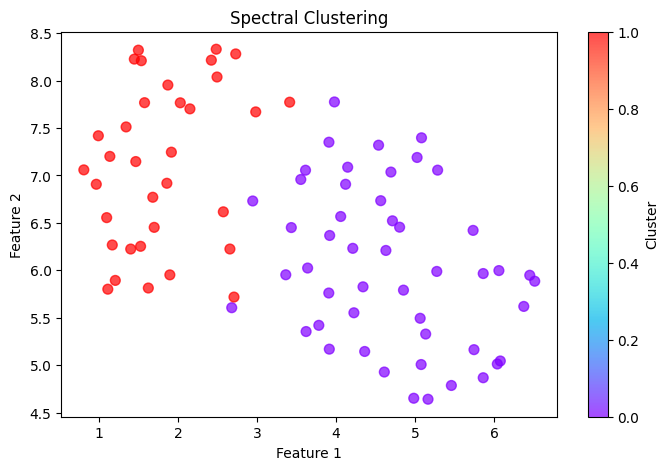

In [30]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering
n_clusters = 2  # Set the number of clusters you want
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral_clustering.fit_predict(mfcc_umap)

# Calculate and print the silhouette score
if n_clusters > 1:  # Silhouette score is not defined for a single cluster
    sil_spec = silhouette_score(mfcc_umap, cluster_labels)
    print(f'Silhouette Score: {sil_spec:.4f}')

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(mfcc_umap[:, 0], mfcc_umap[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title('Spectral Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

In [31]:
print("Perbandingan Silhouette Score")
print(f"KMeans: {sil_kmeans:.4f}")
print(f"DBScan: {sil_dbscan:.4f}")
print(f"Hierarchical: {sil_hc:.4f}")
print(f"PAM: {sil_pam:.4f}")
print(f"Means Shift: {sil_means:.4f}")
print(f"Affinity Propagation: {sil_affi:.4f}")
print(f"Spectral Clustering: {sil_spec:.4f}")

Perbandingan Silhouette Score
KMeans: 0.5203
DBScan: 0.5139
Hierarchical: 0.4066
PAM: 0.4289
Means Shift: 0.5020
Affinity Propagation: 0.5072
Spectral Clustering: 0.5108
